In [1]:

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import random
import shutil
import os
import random
from imutils import paths
import cv2

In [2]:
dataSetPath=os.path.dirname('D:\\abc\\cherry\\')

In [3]:
def getFeaturesArray(dataSetPath):
    imagePaths = list(paths.list_images(f"{dataSetPath}"))
    data = []
    labels = []
    # loop over the image paths
    print('Reading Images')
    for imagePath in imagePaths:
        label = imagePath.split(os.path.sep)[-2]
        image = cv2.imread(imagePath,1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        data.append(image)
        labels.append(label)
    return np.array(data)/255.0,np.array(labels)

In [4]:
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10,10)):
    print('Random samples')
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i][-10:])

In [5]:
INIT_LR = 1e-3
EPOCHS = 5
BS = 20
SAMPLES = 24
TEST_SIZE = 0.30

In [6]:
dataArray, labelArray=getFeaturesArray(dataSetPath)

Reading Images


In [7]:
no_classes = len(np.unique(labelArray))
print('Number of classes',no_classes)

Number of classes 2


Random samples


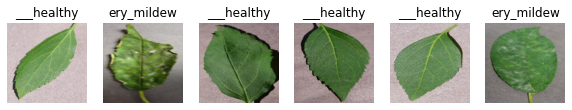

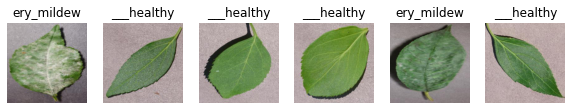

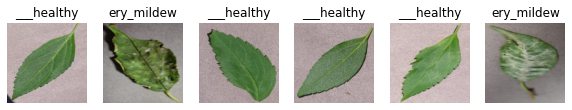

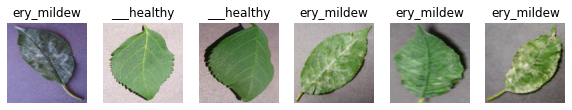

In [8]:
#ramdomImages=random.choices(dataArray,k=SAMPLES)
ramdomNumbers=random.choices(list(range(len(dataArray))),k=SAMPLES)
randomImages=[x for x in dataArray[ramdomNumbers]]
labelRandomImages=[x for x in labelArray[ramdomNumbers]]
#print(len(randomImages))
grid_display(randomImages, labelRandomImages, 6, (10,10))

In [13]:
def Get_Compiled_Model(no_classes):
  baseModel=InceptionV3(input_shape=(224,224,3),include_top=False,input_tensor=Input(shape=(224, 224, 3)))
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5)(headModel)
  headModel = Dense(1, activation="linear")(headModel)
  model= Model(baseModel.input,headModel)
  # for layer in baseModel.layers:
  #   layer.trainable = False
  # compile our model
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model


ERROR! Session/line number was not unique in database. History logging moved to new session 356


In [14]:
no_classes = len(np.unique(labelArray))
print('Number of classes',no_classes)
model = Get_Compiled_Model(no_classes)
model.summary()

Number of classes 2
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
________________________________________________________________________

In [15]:
lb = LabelBinarizer()
binarizedLabels = lb.fit_transform(labelArray)  
(trainX, testX, trainY, testY) = train_test_split(dataArray, binarizedLabels, test_size=TEST_SIZE, random_state=42)

In [16]:
history = model.fit(
    x=trainX,
    y=trainY,
    batch_size=BS,
    epochs=EPOCHS,
    validation_data=(testX, testY),
    steps_per_epoch = 100
)

Train on 2456 samples, validate on 1053 samples
Epoch 1/5
1996/2456 [=======================>......] - ETA: 9s - loss: 0.4457 - accuracy: 0.9509 - val_loss: 0.6263 - val_accuracy: 0.9582

In [17]:
trainX = None

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(
        testX, testY, batch_size=BS, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] loss: {}".format(eval_loss))

1053/1053 [==============================] - 6s 6ms/sample - loss: 0.6263 - accuracy: 0.9582
[INFO] accuracy: 95.82%
[INFO] loss: 0.6262597307151118


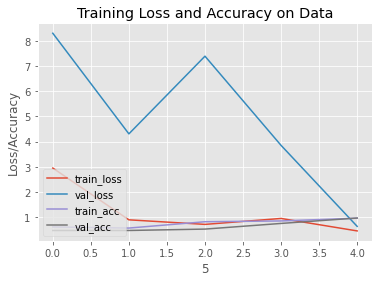

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Data")
plt.xlabel(N)
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [20]:
def myfunc(a):
  return lb.classes_[a]
y_predz = model.predict(testX, batch_size=BS, verbose=1)
y_pred = (y_predz > 0.5) * 1
y_pred = y_pred.reshape(testY.shape)
predicted_Labels = map(myfunc, y_pred)
print(classification_report(list(lb.inverse_transform(testY))[:],list(lb.inverse_transform(y_pred))[:]))

1053/1053 [==============================] - 7s 7ms/sample
                                          precision    recall  f1-score   support

Cherry_(including_sour)___Powdery_mildew       1.00      0.91      0.95       485
       Cherry_(including_sour)___healthy       0.93      1.00      0.96       568

                                accuracy                           0.96      1053
                               macro avg       0.96      0.95      0.96      1053
                            weighted avg       0.96      0.96      0.96      1053

